## Examining the Relationship Between Economic Instability of Several Countries and BitCoin Market Capitalization

### Authors: Achal Srinivasan and Corrin Fosmire

### Section 1: Setting up Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import time
import datetime as dt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,7)

/home/infrared/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
#using IMF API, acquire information for a particular country
def generate_data(country_abbr="US", metric="PXP_IX", resolution="M", start=2009, end=2017):
    data = requests.get("http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/"+resolution+"."+country_abbr+"."+metric+".?startPeriod="+str(start)+"&endPeriod="+str(end)).json()
    df = pd.DataFrame(data['CompactData']['DataSet']['Series']['Obs'])
    df = df.rename(index=str, columns={"@OBS_VALUE" : country_abbr+"."+metric, "@TIME_PERIOD" : "date"})
    return df

In [3]:
#loading economic health data for certain countries"

countries = ["US", "KR", "CN"]
#United States, South, Korea, China

metrics = ["PCPI_IX", "ENDE_XDC_USD_RATE", "LE_IX"]
#consumer price index (should indicate inflation), exchange rate (in domestic currency), employment index

print(generate_data(country_abbr="KR",metric="LE_IX").head())

           VE.LE_IX     date
0  95.2845153189527  2009-01
1  96.6061907446666  2009-02
2  98.9964787569285  2009-03
3  100.581520598223  2009-04
4  99.1473978082267  2009-05


In [4]:
def make_dataset(countries, metrics):
    #make first table, so then we can do joins on the rest
    empty = True
    full_data = None
    
    for country in countries:
        for metric in metrics:
            if empty:
                full_data = generate_data(country_abbr=country, metric=metric)
                empty = False
            else:
                metric_data = generate_data(country_abbr=country, metric=metric)
                full_data = full_data.merge(metric_data, on="date")
        time.sleep(5) #avoid throttling
                

    return full_data

In [5]:
financial_data = make_dataset(countries, metrics)

In [6]:
#deleting status variables we don't really care about
financial_data = financial_data[list(filter(lambda a: not a[0] == "@", list(financial_data.columns.values)))]

In [7]:
financial_data["date"] = financial_data["date"]+"-01"

In [8]:
#loading bitcoin data
btc_data = pd.read_csv("btc.csv")
btc_data = btc_data[btc_data["marketcap(USD)"] != np.nan]

#selecting columns of interest
mc_date = btc_data[["date","marketcap(USD)"]]

#converting to date time format
mc_date['date'] = pd.to_datetime(mc_date['date'])
mc_date = mc_date.dropna()

#years = [2013,2014,2015,2016]

#mc_date = mc_date[mc_date['date'].dt.year.isin(years) & mc_date['date'].dt.day.isin([1])]
mc_date['date'] = mc_date['date'].dt.strftime(date_format="%Y-%m-%d")
mc_date.head()

/home/infrared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,date,marketcap(USD)
1570,2013-04-28,1.500656e+09
1571,2013-04-29,1.491703e+09
1572,2013-04-30,1.598310e+09
1573,2013-05-01,1.543334e+09
1574,2013-05-02,1.292577e+09


In [9]:
combined = mc_date.merge(financial_data, on="date", how="left")
combined['date'] = pd.to_datetime(combined['date'])

#convert data to numbers for interpolation & inference
for country in countries:
    for metric in metrics:
        combined[country+"."+metric] = pd.to_numeric(combined[country+"."+metric])

combined = combined.interpolate(method='linear').dropna()
combined.head()

,date,marketcap(USD),US.PCPI_IX
3,2013-05-01,1.543334e+09,106.828307
4,2013-05-02,1.292577e+09,106.836577
5,2013-05-03,1.180430e+09,106.844847
6,2013-05-04,1.090276e+09,106.853116
7,2013-05-05,1.255228e+09,106.861386


In [10]:
combined.tail()

,date,marketcap(USD),US.PCPI_IX
2018,2018-11-06,1.116162e+11,113.055621
2019,2018-11-07,1.123253e+11,113.055621
2020,2018-11-08,1.132688e+11,113.055621
2021,2018-11-09,1.118954e+11,113.055621
2022,2018-11-10,1.109251e+11,113.055621


### Section 2: Exploratory Data Analysis

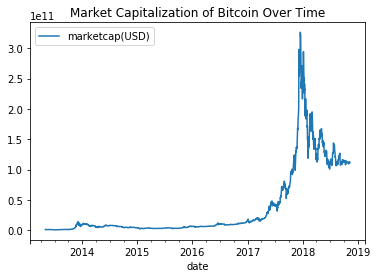

In [11]:
combined.plot(x='date',y='marketcap(USD)', title="Market Capitalization of Bitcoin Over Time")

#### We note that the market cap of BitCoin skyrocketed at the end of 2013, then gradually declined until 2015, where it rebounded again.

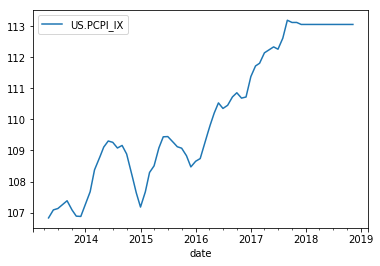

In [12]:
ax = combined.plot(x='date',y='US.PCPI_IX')
#combined.plot(x='date',y='TR.PCPI_IX', ax=ax)
#combined.plot(x='date',y='VE.PCPI_IX', ax=ax)
#combined.plot(x='date',y='UY.PCPI_IX', ax=ax, title="Inflation Rates of US, Turkey, Venezuela, Uruguay")

#### Clearly, Venezuela's inflation rate is far, far greater than the other countries, and has been increasing more and more quickly with time.

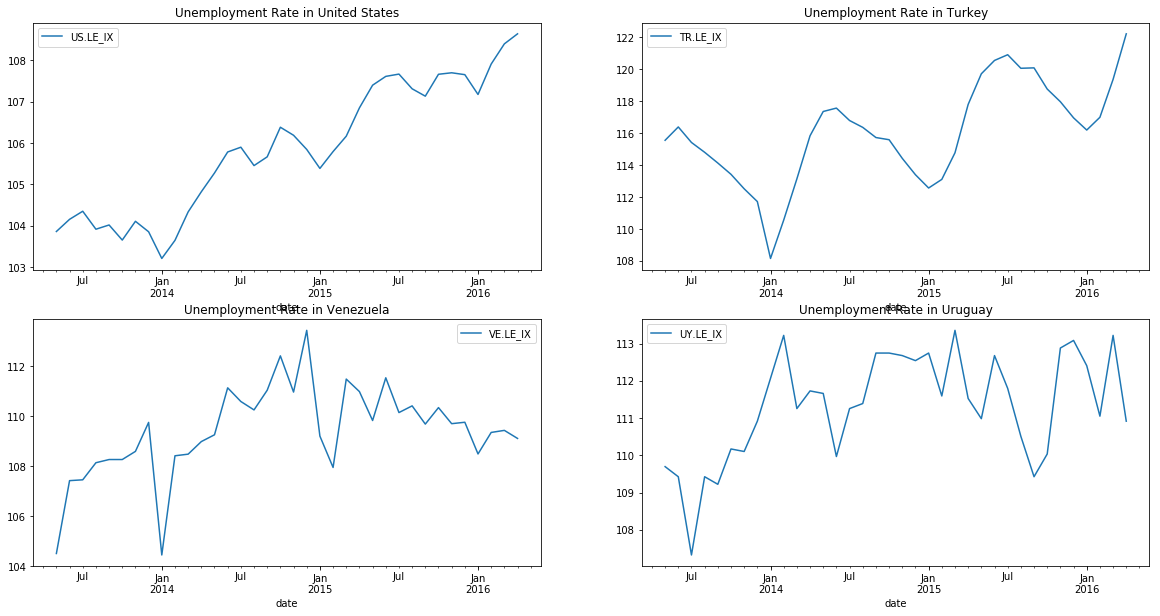

In [13]:
plt.rcParams['figure.figsize'] = (20,10)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

combined.plot(x='date',y='US.LE_IX', ax=ax1, title="Unemployment Rate in United States")
combined.plot(x='date',y='TR.LE_IX', ax=ax2, title="Unemployment Rate in Turkey")
combined.plot(x='date',y='VE.LE_IX', ax=ax3, title="Unemployment Rate in Venezuela")
combined.plot(x='date',y='UY.LE_IX', ax=ax4, title="Unemployment Rate in Uruguay")

#### Three of the countries had notably low unemployment rates in January 2014. Turkey seems to have a high degree of cyclical unemployment, and the United States and Turkey both have an upward trend. Venezuela and Uruguay have less of a trend but more volatility.

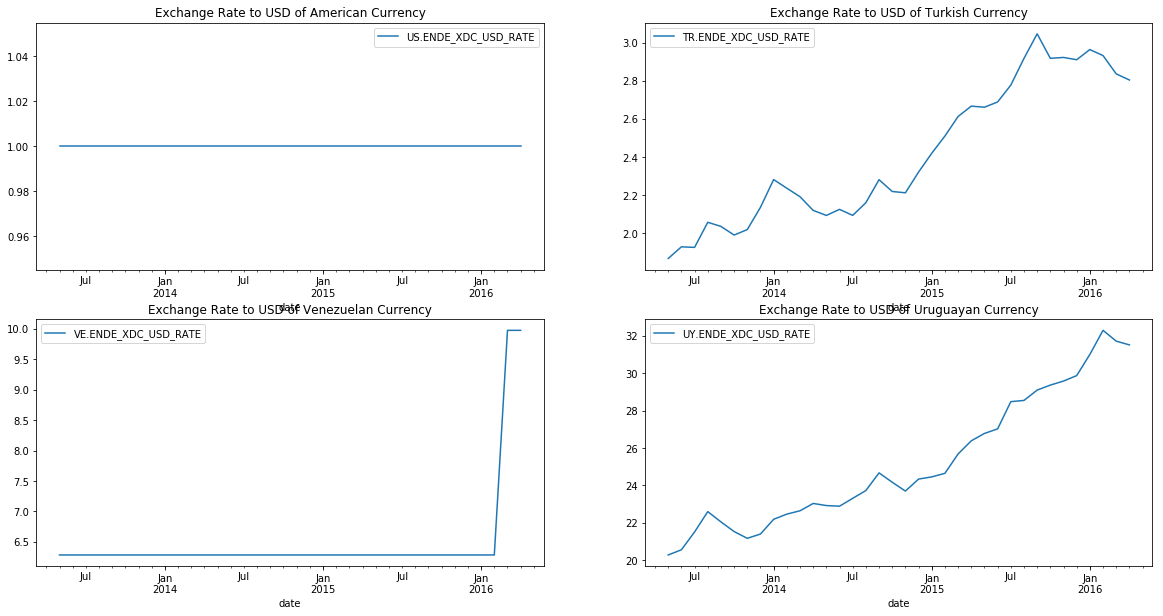

In [14]:
plt.rcParams['figure.figsize'] = (20,10)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

combined.plot(x='date',y='US.ENDE_XDC_USD_RATE', ax=ax1, title="Exchange Rate to USD of American Currency")
combined.plot(x='date',y='TR.ENDE_XDC_USD_RATE', ax=ax2, title="Exchange Rate to USD of Turkish Currency")
combined.plot(x='date',y='VE.ENDE_XDC_USD_RATE', ax=ax3, title="Exchange Rate to USD of Venezuelan Currency")
combined.plot(x='date',y='UY.ENDE_XDC_USD_RATE', ax=ax4, title="Exchange Rate to USD of Uruguayan Currency")

#### Clearly, the exchange rate in USD of USD is 1, which explains the line of the American currency. All three other currencies have been devalued relative to the USD steadily from 2013 to 2016, with the price of Venezuela markedly exploding in value after 2016, almost doubling in value.

### Section 3: Modeling

#### We will build models with and without exogenous regressors to predict BitCoin market cap, using both SARIMAX and Facebook Prophet models.

In [13]:
import fbprophet
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

In [14]:
#test/train split
cryptoecon_train = combined[combined['date'] < pd.to_datetime('2018-01-01')]
cryptoecon_test = combined[combined['date'] >= pd.to_datetime('2018-01-01')]

In [15]:
#prophet dataframe preparation
prophet_df = pd.DataFrame(cryptoecon_train)
prophet_df['ds'] = prophet_df['date']
prophet_df['y'] = prophet_df['marketcap(USD)']

prophet_test = pd.DataFrame(cryptoecon_test)
prophet_test['ds'] = prophet_test['date']
prophet_test['y'] = prophet_test['marketcap(USD)']

In [25]:
#creating a model with no exogenous variables
no_exo_m = fbprophet.Prophet(daily_seasonality=True)
no_exo_m.fit(prophet_df)

#creating a model with all exogenous variables
all_exo_m = fbprophet.Prophet(daily_seasonality=True)

for country in countries:
    for metric in metrics:
        all_exo_m.add_regressor(country+"."+metric)
        
all_exo_m.fit(prophet_df)

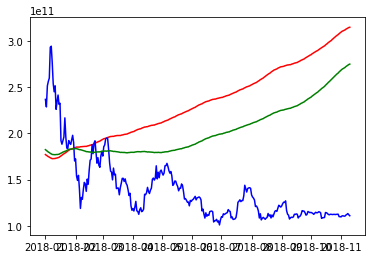

In [26]:
no_exo_preds = no_exo_m.predict(prophet_test)
all_exo_preds = all_exo_m.predict(prophet_test)

plt.plot(prophet_test['ds'].values, no_exo_preds['yhat'].values, c="r")
plt.plot(prophet_test['ds'].values, prophet_test['marketcap(USD)'].values, c="b")
plt.plot(prophet_test['ds'].values, all_exo_preds['yhat'].values, c="g")

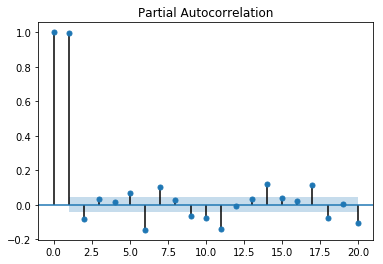

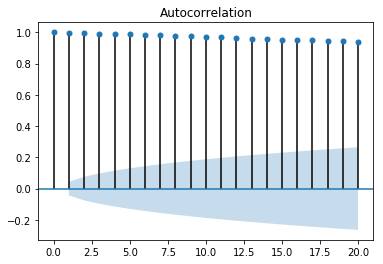

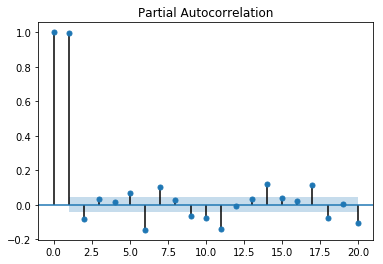

In [18]:
plot_acf(combined['marketcap(USD)'],lags=20)
plot_pacf(combined['marketcap(USD)'],lags=20)

#### Based on the above autocorrelation and partial autocorrelation plots, we estimate that the parameter p of the ARIMA model is about 2.

In [19]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [20]:
adf_test(cryptoecon_train['marketcap(USD)'])

Results of Dickey-Fuller Test:
Test Statistic                    6.198210
p-value                           1.000000
#Lags Used                       25.000000
Number of Observations Used    1680.000000
Critical Value (1%)              -3.434248
Critical Value (5%)              -2.863262
Critical Value (10%)             -2.567687
dtype: float64


In [21]:
adf_test(cryptoecon_train['marketcap(USD)'].diff(2).dropna())

Results of Dickey-Fuller Test:
Test Statistic                -1.051386e+01
p-value                        1.008153e-18
#Lags Used                     2.500000e+01
Number of Observations Used    1.678000e+03
Critical Value (1%)           -3.434253e+00
Critical Value (5%)           -2.863264e+00
Critical Value (10%)          -2.567688e+00
dtype: float64


In [22]:
no_exog_sari = SARIMAX(cryptoecon_train['marketcap(USD)'],order=(2,2,0))
no_exog_sarim = no_exog_sari.fit()

#creating exogenous variables: just drop date and marketcap from training data and convert to array
exog = cryptoecon_train.drop(['marketcap(USD)','date','ds','y'], axis=1).values.astype(float)

all_exog_sari = SARIMAX(cryptoecon_train['marketcap(USD)'], exog, order=(2,2,0))
all_exog_sarim = all_exog_sari.fit()

/home/infrared/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/infrared/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:
/home/infrared/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


/home/infrared/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/infrared/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


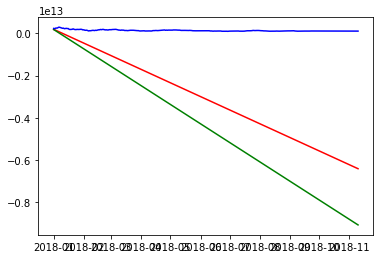

In [24]:
exog = cryptoecon_test.drop(['marketcap(USD)','date','ds','y'], axis=1).values.astype(float)

sarim_no_predix = no_exog_sarim.get_forecast(314).predicted_mean
sarim_all_predix = all_exog_sarim.get_forecast(314, exog=exog).predicted_mean

cryptoecon_test['date'].values

plt.plot(cryptoecon_test['date'].values,sarim_no_predix, c='r')
plt.plot(cryptoecon_test['date'].values,sarim_all_predix, c='g')
plt.plot(cryptoecon_test['date'].values,cryptoecon_test['marketcap(USD)'].values, c='b')

### Section 4: Data Visualization